# medARC

Figure 6 and Supplementary Figures 

In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scienceplots
import seaborn as sns
import string
import sys
from collections import Counter

plt.style.use(['nature'])
plt.rcParams['figure.dpi'] = 300

def brier_score(df, prob_c, true_c):
    """
    Calculate Brier score
    Parameters: df (pd.Dataframe) containing probabilities and true labels
    Returns: (float), Brier score
    """
    sq_diff = np.square(df[prob_c] - df[true_c])
    return sq_diff.mean()


def calculate_entropy_based_consistency(answers):
    """
    Calculate entropy-based consistency, following Lyu et al. (2024)
    Parameters: answers (list) generated by the model for the same question.
    Returns: (float), entropy-based consistency score (range [0, 1]).
    """
    answers = [a if pd.notna(a) else "nan" for a in answers]
    value,counts = np.unique(answers, return_counts=True)
    norm_counts = counts / counts.sum()
    base = len(value) # cardinality of unique answer set
    if base == 1:
        norm_ent = 0
    else:
        norm_ent = -(norm_counts * np.log(norm_counts)/np.log(base)).sum()
    return 1 - norm_ent    

    
def calculate_sc_ent(df):
    """
    Calculate entropy-based consistency, following Lyu et al. (2024)
    Parameters: df (pd.DataFrame), where each column represents a question
                       and each row represents a run of the model.
    Returns: pd.Series, consistency scores for each question.
    """
    consistency_scores = df.apply(calculate_entropy_based_consistency, axis=0)
    return consistency_scores


def fix_model_name(model_name):
    model_name = model_name.replace(r'-Instruct-*', '')
    model_name = model_name.replace(r'v0.1', '')
    model_name = model_name.replace(r'-20240229', '')
    model_name = model_name.replace(r'-2024-12-17', '')
    model_name = model_name.replace(r'claude', 'Claude')
    model_name = model_name.replace(r'gemini', 'Gemini')
    model_name = model_name.replace(r'-latest', '')
    return model_name

In [2]:
# Testing 
df = pd.DataFrame({
    "question_ID001": ["D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D", "D"],
    "question_ID002": ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", np.nan, "A", "A"],
    "question_ID003": ["A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", np.nan, np.nan, "A", "A", "A"],
    "question_ID004": ["A", "C", "A", "D", "C", "E", "B", "X", "A", "Y", "Z", "Y", "Q", np.nan, "A2", "A4"]
})

sc_ent_scores = calculate_sc_ent(df)
print(sc_ent_scores) # higher entropy equates to higher confidence answers


question_ID001    1.000000
question_ID002    0.662710
question_ID003    0.456436
question_ID004    0.036860
dtype: float64


In [3]:
main_path = 'eval_uq_results'
model_result_paths = glob.glob(os.path.join(main_path, '*/'))

all_model_uq_results = {}
all_model_cal_agr_results = {}
all_model_cal_ent_results = {}
all_model_bs_agree_results = {}
all_model_bs_entropy_results = {}
all_model_raw_results = {} # RAW ACCURACY WITHOUT UQ

for model_path in model_result_paths:

    uq_file_pattern = os.path.join(model_path, 'run*/*_health_result.json')
    uq_file_paths = glob.glob(uq_file_pattern)

    final_df = pd.DataFrame()
    
    for n, file_path in enumerate(uq_file_paths):
        try:
            with open(file_path, 'r') as f:
                content = json.load(f)
            
            pred_dict = {item["question_id"]: item["pred"] for item in content}
            pred_df = pd.DataFrame([pred_dict])
            pred_df.columns = [f"question_{col}" for col in pred_df.columns]
            final_df = pd.concat([final_df, pred_df], ignore_index=True)

            if n == 0:
                correct_answers = {}
                for item in content:
                    answer = item["answer"] 
                    if answer == None:
                        mult_choice_answers = list(string.ascii_uppercase[:27])
                        answer_idx = item['answer_index']
                        answer = mult_choice_answers[answer_idx]
                    correct_answers[item["question_id"]] = answer
                     
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
        sample_consistency = {}
        
        for n, col in enumerate(final_df.columns):
            counts = Counter(final_df[col])
            most_common_response, most_common_count = counts.most_common(1)[0]

            total_responses = len(final_df[col])
            consistency_fraction = most_common_count / total_responses
            
            question_id = col.split('_')[1]

            # Check if most common response matches the correct answer
            is_correct = 1 if most_common_response == correct_answers.get(question_id) else 0
            
            sample_consistency[question_id] = {
                "sample_consistency_agree": consistency_fraction,
                "correct": is_correct
            }

        
        sample_consistency_df = pd.DataFrame.from_dict(sample_consistency, orient='index')
        sample_consistency_df.index.name = 'question_id'

        sc_ent_scores = calculate_sc_ent(final_df)

        model_name = model_path.split('/')[1]
        model_name = fix_model_name(model_name)

        all_model_uq_results[model_name] = {'Sample Consistency (Agr)': sample_consistency_df['sample_consistency_agree'].mean(),
                                            'Sample Consistency (Ent)': sc_ent_scores.mean(),
                                            'Accuracy': sample_consistency_df['correct'].mean(), 
                                           }

        # Add entropy confidence scores
        sample_consistency_df['sample_consistency_ent'] = sc_ent_scores.values

        # Reliability Plots, first bin 'confidence' into deciles
        sample_consistency_df['confidence_bin_agr'] = pd.qcut(sample_consistency_df.rank(method='first')['sample_consistency_agree'], 
                                                            7, duplicates='raise')
        
        # Calculate mean confidence, accuracy for each bin 
        all_model_cal_agr_results[model_name] = sample_consistency_df.groupby('confidence_bin_agr', observed=False).agg(
            average_confidence_agr=('sample_consistency_agree', lambda x: x.mean() ),
            observed_accuracy=('correct', lambda x: x.mean() * 100)
        )

        # Bin 'confidence' into deciles
        sample_consistency_df['confidence_bin_ent'] = pd.qcut(sample_consistency_df.rank(method='first')['sample_consistency_ent'], 
                                                            5, duplicates='raise')
        
        # Calculate mean confidence, accuracy for each bin 
        all_model_cal_ent_results[model_name] = sample_consistency_df.groupby('confidence_bin_ent', observed=False).agg(
            average_confidence_ent=('sample_consistency_ent', lambda x: x.mean() ),
            observed_accuracy=('correct', lambda x: x.mean() * 100)
        )

        # Calculate Brier Scores
        all_model_bs_agree_results[model_name] = brier_score(sample_consistency_df, 'sample_consistency_agree', 'correct')
        all_model_bs_entropy_results[model_name] = brier_score(sample_consistency_df, 'sample_consistency_ent', 'correct')

    
    # RAW ACCURACY PER RUN WITHOUT UNCERTAIN QUANTIFICATION
    file_pattern = os.path.join(model_path, 'run*/*_health_summary.json')
    file_paths = glob.glob(file_pattern)
        
    data = []
    for file_path in file_paths:
        try:
            with open(file_path, 'r') as f:
                content = json.load(f)
            
            accuracy = content['health']['acc']
            
            model_name = os.path.basename(file_path).replace('_health_summary.json', '')  # Remove the suffix to get the model name
            model_name = fix_model_name(model_path)

            data.append({'model': model_name, 'accuracy': accuracy})
        
        except (FileNotFoundError, json.JSONDecodeError, KeyError) as e:
            print(f"Error processing file {file_path}: {e}")

    df = pd.DataFrame(data)
    df['model'] = df['model'].str.replace(r'-Instruct-*', '', regex=True)
    df['model'] = df['model'].str.replace(r'v0.1', '', regex=True)
    df['model'] = df['model'].str.replace(r'-20240229', '', regex=True)
    df['model'] = df['model'].str.replace(r'-20241217', '', regex=True)

    all_model_raw_results[model_name] = [df.loc[:, 'accuracy'].mean(), df.loc[:, 'accuracy'].std()]

In [4]:
all_model_bs_entropy_results

{'Claude-3-opus': 0.5126263014506041,
 'Llama-3.1-70B-Instruct': 0.45496476062295693,
 'Llama-3.1-8B-Instruct': 0.4557827103033588,
 'Gemini-1.5-pro': 0.37330487292924736,
 'Claude-3-sonnet': 0.6214685923607594,
 'Gemini-1.5-flash': 0.5907728233743808,
 'gpt-4o-mini': 0.7587807696049182,
 'o1': 0.28847940833937014}

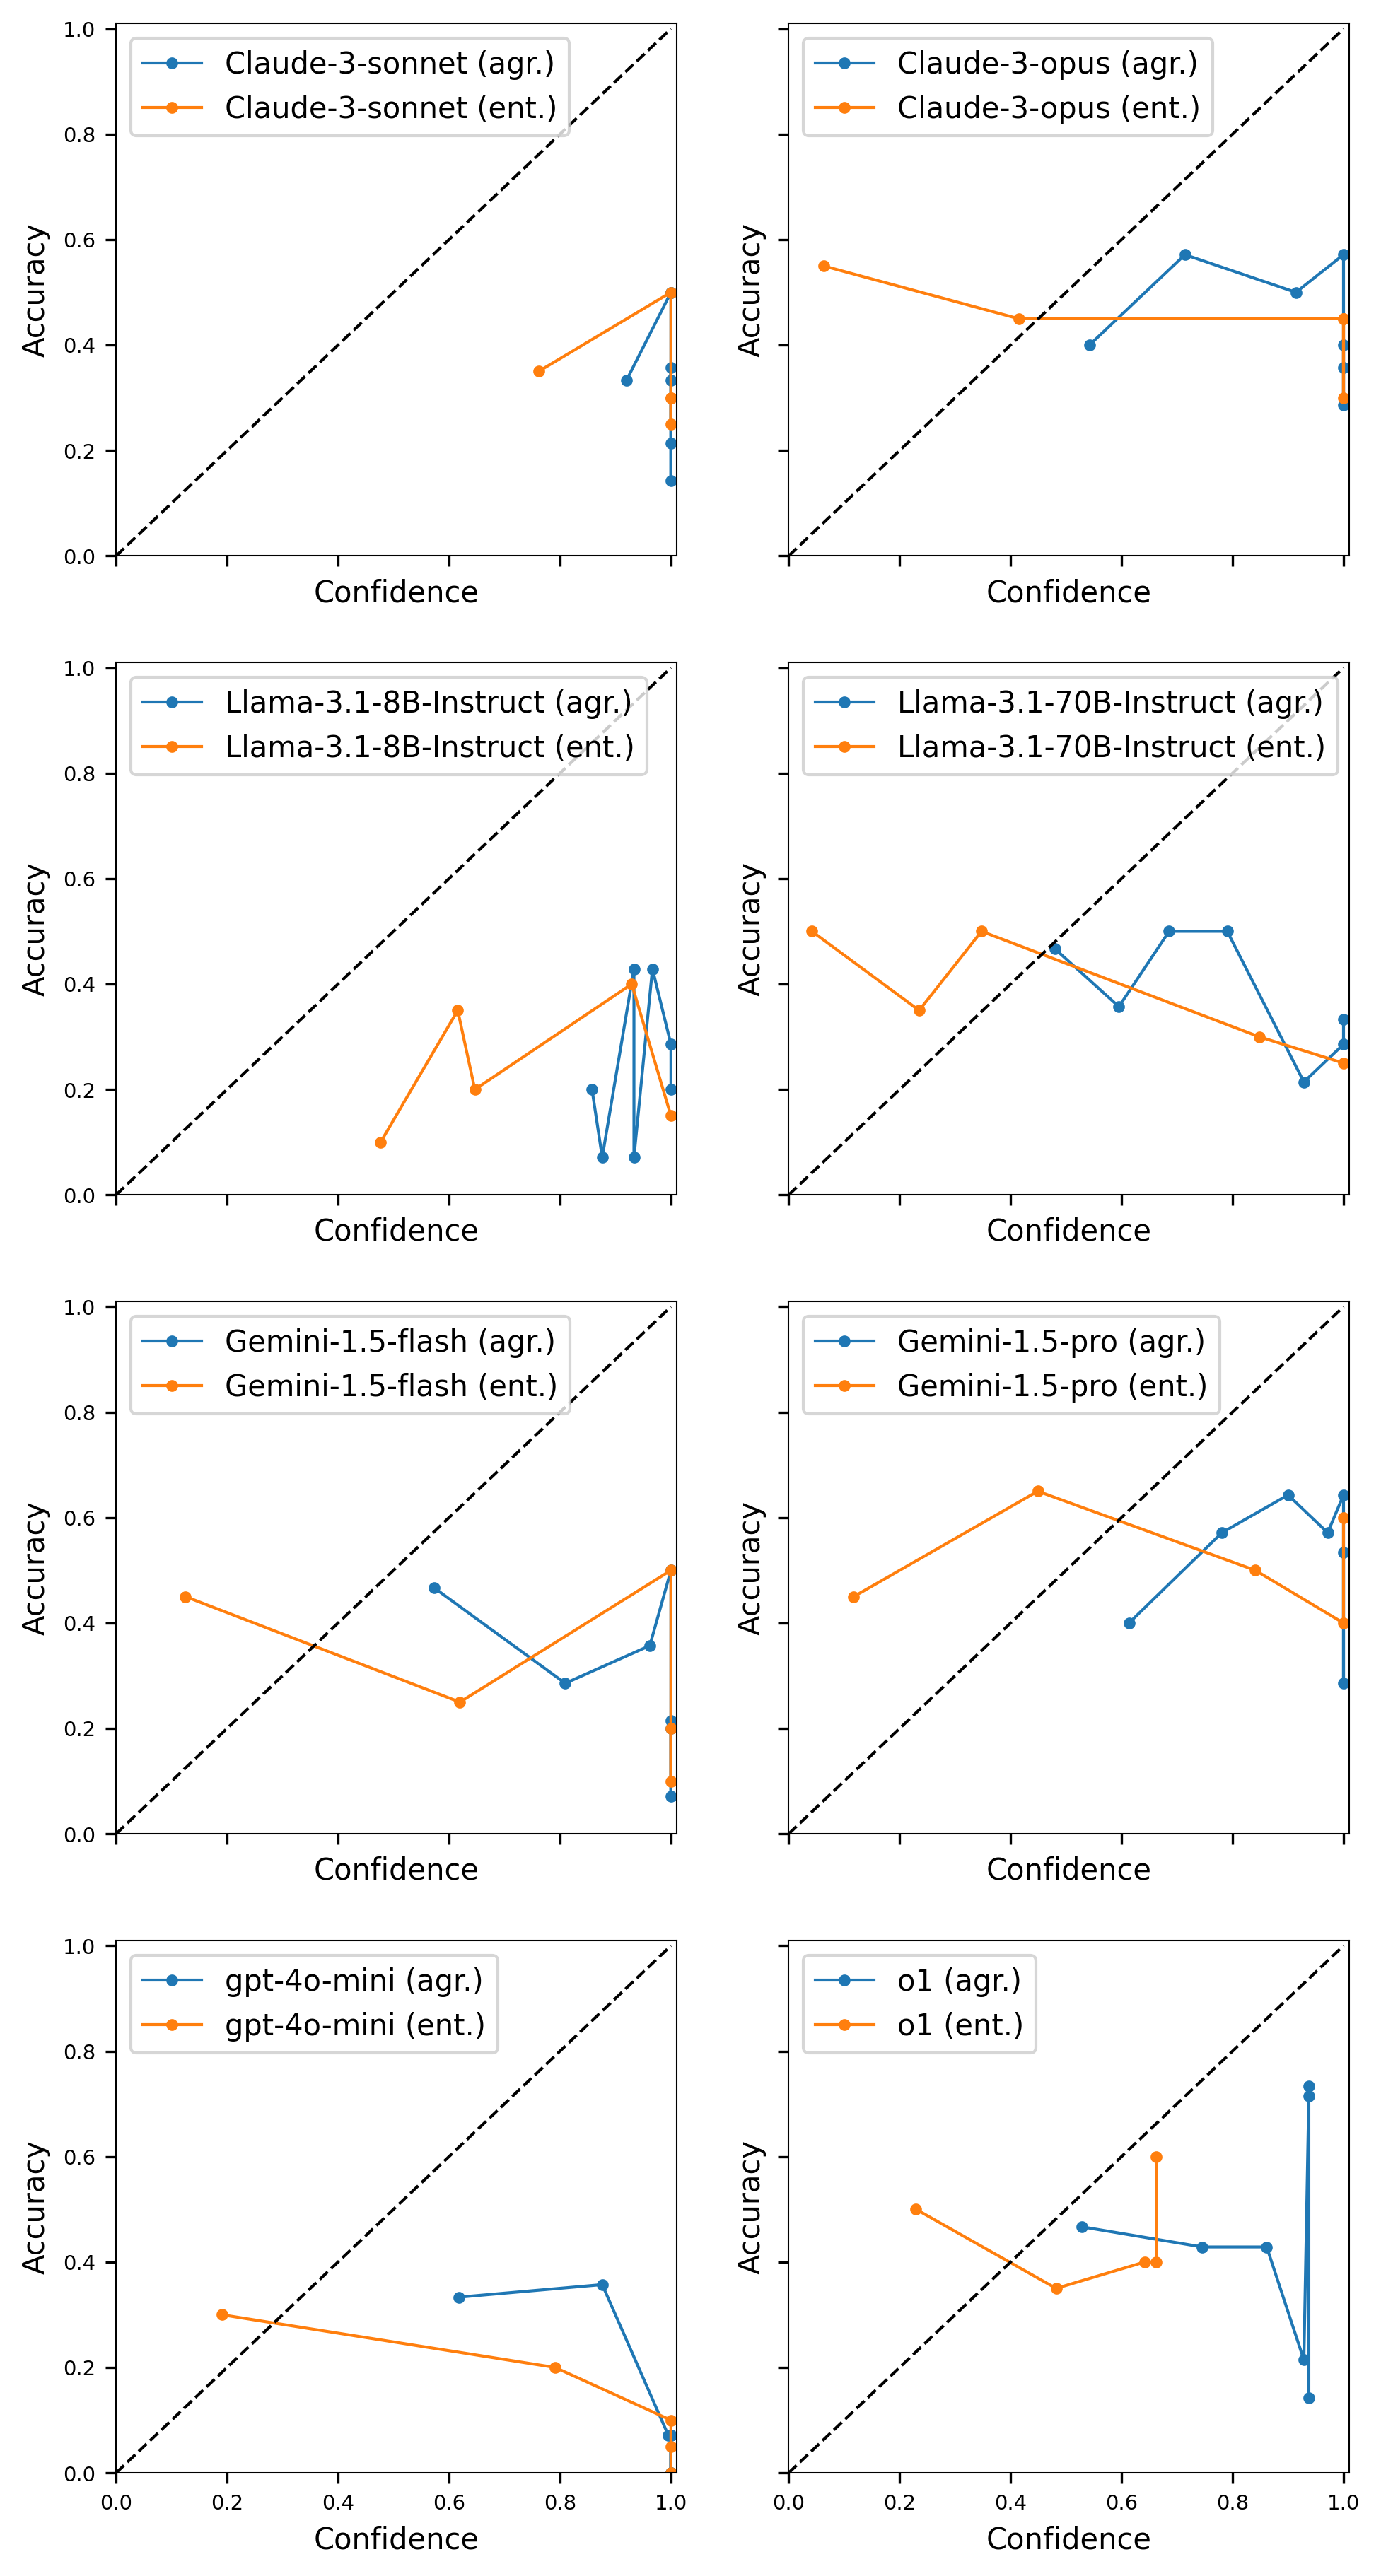

In [6]:

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(7.5,15), sharex=True, sharey=True)
axes = axes.flatten()
i = 0

for model in ['Claude-3-sonnet', 'Claude-3-opus', 
              'Llama-3.1-8B-Instruct', 'Llama-3.1-70B-Instruct', 
            'Gemini-1.5-flash', 'Gemini-1.5-pro', 
              'gpt-4o-mini', 'o1']:
    cal_agr_res = all_model_cal_agr_results[model]
    cal_ent_res = all_model_cal_ent_results[model]

    ax = axes[i]
    ax.plot(cal_agr_res['average_confidence_agr'], 
            cal_agr_res['observed_accuracy']/100, marker='o', linestyle='-',  
            label=model + ' (agr.)',linewidth=1)
    ax.plot(cal_ent_res['average_confidence_ent'], 
            cal_ent_res['observed_accuracy']/100, marker='o', linestyle='-',  
            label=model + ' (ent.)',linewidth=1)
    
    ax.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    ax.set_xlabel('Confidence',fontsize=10)
    ax.set_ylabel('Accuracy',fontsize=10)
    ax.set_ylim(0, 1.01)
    ax.set_xlim(0, 1.01)
# plt.title('GPT Annotation',fontsize = 12)
    ax.legend(fontsize=10,loc='upper left')
    i+=1
plt.grid(False)
plt.show()


In [11]:
# Prepare for plotting agreement-based SC
df_bs = pd.DataFrame(all_model_bs_agree_results.items(), columns=['Model (det)', 'Brier Score'])

family = []
for m in df_bs['Model (det)']:
    if 'claude' in m:
        family.append('Claude')
    elif 'Llama' in m:
        family.append('Llama')
    elif 'gemini' in m:
        family.append('Gemini')
    else:
        family.append('OpenAI')

df_bs['Family'] = family
df_bs['Model Size'] = ['Large', 'Large', 'Small', 'Large', 'Small', 'Small', 'Small', 'Large']
df_bs['Model'] = ['Claude Opus', 'Llama-3.1-70B', 'Llama-3.1-8B', 'Gemini-1.5-Pro', 'Claude-3-Sonnet',
                    'Gemini-1.5-Flash', 'GPT-4o', 'o1']
df_bs = df_bs.sort_values(['Family', 'Model'], ascending=[True, False])
df_bs

,Model (det),Brier Score,Family,Model Size,Model
2,Llama-3.1-8B-Instruct,0.668222,Llama,Small,Llama-3.1-8B
1,Llama-3.1-70B-Instruct,0.467333,Llama,Large,Llama-3.1-70B
7,o1,0.422031,OpenAI,Large,o1
3,Gemini-1.5-pro,0.401511,OpenAI,Large,Gemini-1.5-Pro
5,Gemini-1.5-flash,0.622667,OpenAI,Small,Gemini-1.5-Flash
6,gpt-4o-mini,0.802489,OpenAI,Small,GPT-4o
4,Claude-3-sonnet,0.645333,OpenAI,Small,Claude-3-Sonnet
0,Claude-3-opus,0.485644,OpenAI,Large,Claude Opus


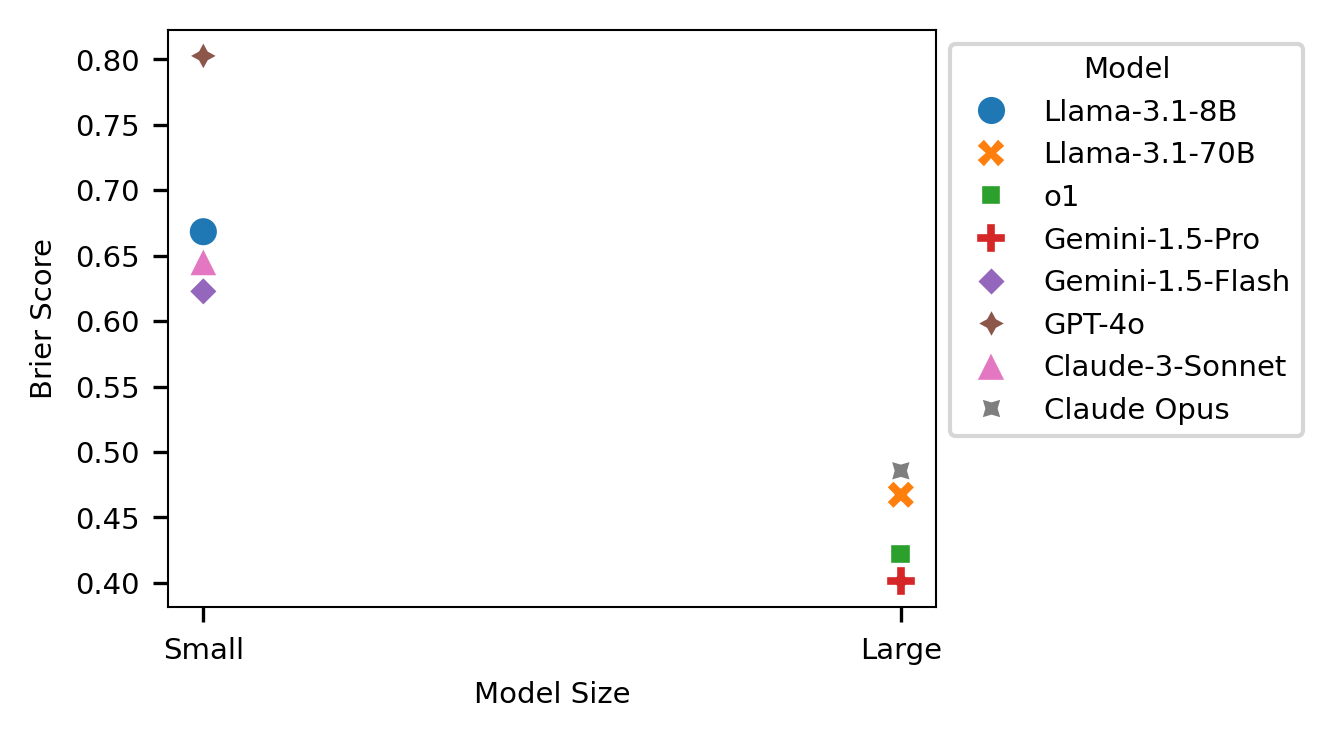

In [12]:
ax = sns.scatterplot(data=df_bs, x="Model Size", y="Brier Score", s=50, 
                     hue="Model", style="Model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

In [13]:
# Prepare for plotting entropy-based SC

# Convert dictionary to DataFrame
df_bs_ent = pd.DataFrame(all_model_bs_entropy_results.items(), columns=['Model (det)', 'Brier Score'])

family = []
for m in df_bs_ent['Model (det)']:
    if 'claude' in m:
        family.append('Claude')
    elif 'Llama' in m:
        family.append('Llama')
    elif 'gemini' in m:
        family.append('Gemini')
    else:
        family.append('OpenAI')

df_bs_ent['Family'] = family
df_bs_ent['Model Size'] = ['Large', 'Large', 'Small', 'Large', 'Small', 'Small', 'Small', 'Large']
df_bs_ent['Model'] = ['Claude Opus', 'Llama-3.1-70B', 'Llama-3.1-8B', 'Gemini-1.5-Pro', 'Claude-3-Sonnet',
                    'Gemini-1.5-Flash', 'GPT-4o', 'o1']
df_bs_ent = df_bs_ent.sort_values(['Family', 'Model'], ascending=[True, False])
df_bs_ent

,Model (det),Brier Score,Family,Model Size,Model
2,Llama-3.1-8B-Instruct,0.455783,Llama,Small,Llama-3.1-8B
1,Llama-3.1-70B-Instruct,0.454965,Llama,Large,Llama-3.1-70B
7,o1,0.288479,OpenAI,Large,o1
3,Gemini-1.5-pro,0.373305,OpenAI,Large,Gemini-1.5-Pro
5,Gemini-1.5-flash,0.590773,OpenAI,Small,Gemini-1.5-Flash
6,gpt-4o-mini,0.758781,OpenAI,Small,GPT-4o
4,Claude-3-sonnet,0.621469,OpenAI,Small,Claude-3-Sonnet
0,Claude-3-opus,0.512626,OpenAI,Large,Claude Opus


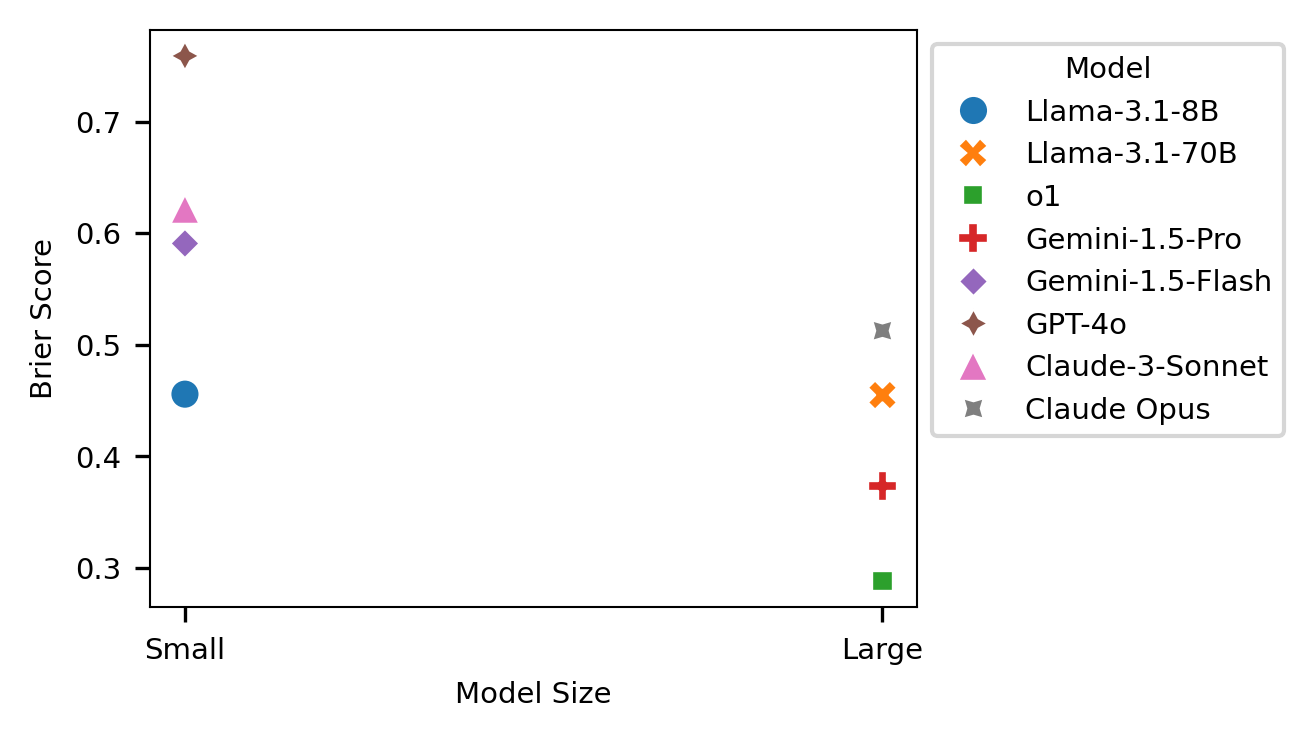

In [14]:
ax = sns.scatterplot(data=df_bs_ent, x="Model Size", y="Brier Score", s=50, 
                     hue="Model", style="Model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

In [19]:
# Plot raw SC

In [20]:
df_sc = pd.DataFrame(all_model_uq_results).transpose()
df_sc['Model (det)'] = df_sc.index

family = []
for m in df_sc['Model (det)']:
    if 'claude' in m:
        family.append('Claude')
    elif 'Llama' in m:
        family.append('Llama')
    elif 'gemini' in m:
        family.append('Gemini')
    else:
        family.append('OpenAI')

df_sc['Family'] = family
df_sc['Model Size'] = ['Large', 'Large', 'Small', 'Large', 'Small', 'Small', 'Small', 'Large']
df_sc['Model'] = ['Claude Opus', 'Llama-3.1-70B', 'Llama-3.1-8B', 'Gemini-1.5-Pro', 'Claude-3-Sonnet',
                    'Gemini-1.5-Flash', 'GPT-4o', 'o1']
df_sc = df_sc.sort_values(['Family', 'Model Size'], ascending=[True, False])
df_sc

,Sample Consistency (Agr),Sample Consistency (Ent),Accuracy,Model (det),Family,Model Size,Model
Llama-3.1-8B-Instruct,0.938000,0.733697,0.24,Llama-3.1-8B-Instruct,Llama,Small,Llama-3.1-8B
Llama-3.1-70B-Instruct,0.782000,0.494577,0.38,Llama-3.1-70B-Instruct,Llama,Large,Llama-3.1-70B
Claude-3-sonnet,0.988000,0.952300,0.34,Claude-3-sonnet,OpenAI,Small,Claude-3-Sonnet
Gemini-1.5-flash,0.904000,0.749007,0.30,Gemini-1.5-flash,OpenAI,Small,Gemini-1.5-Flash
gpt-4o-mini,0.924667,0.796360,0.13,gpt-4o-mini,OpenAI,Small,GPT-4o
Claude-3-opus,0.879333,0.695605,0.44,Claude-3-opus,OpenAI,Large,Claude Opus
Gemini-1.5-pro,0.893333,0.681456,0.52,Gemini-1.5-pro,OpenAI,Large,Gemini-1.5-Pro
o1,0.837500,0.535746,0.45,o1,OpenAI,Large,o1


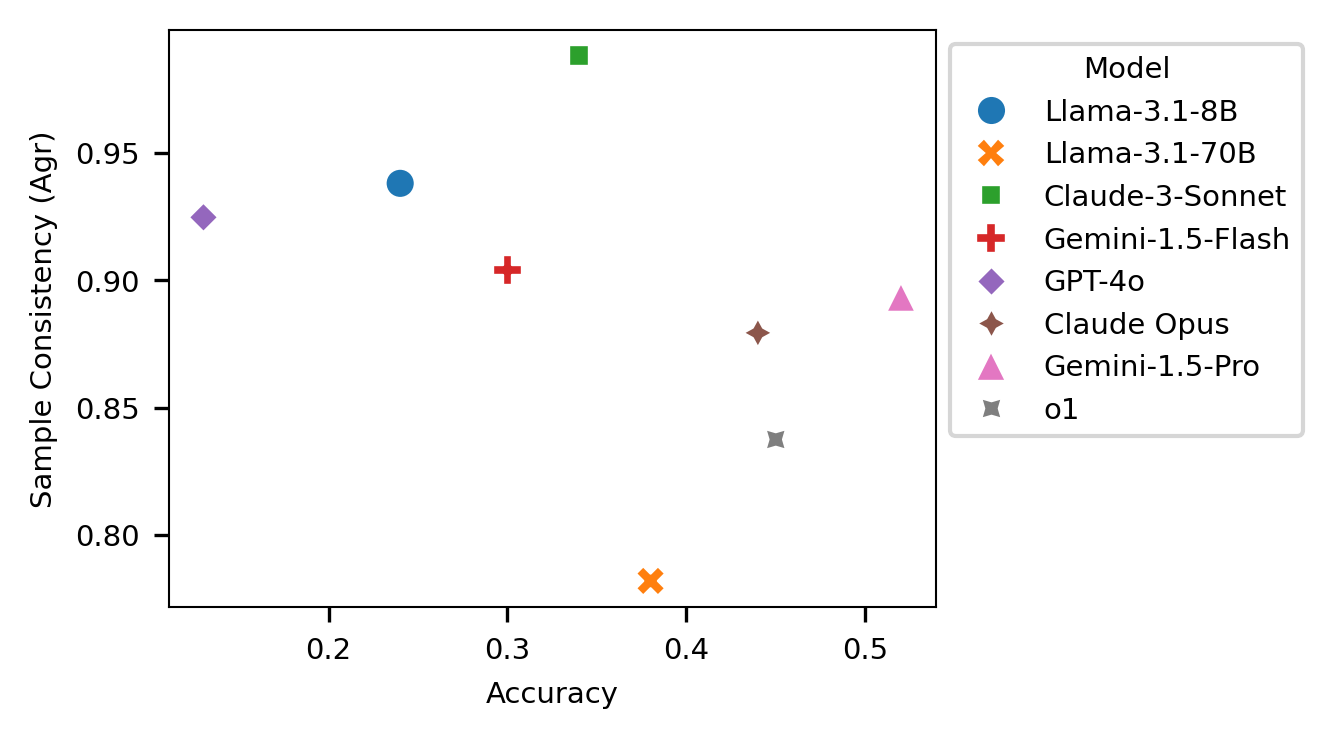

In [21]:
ax = sns.scatterplot(data=df_sc, x="Accuracy", y="Sample Consistency (Agr)", s=50, 
                     hue="Model", style="Model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

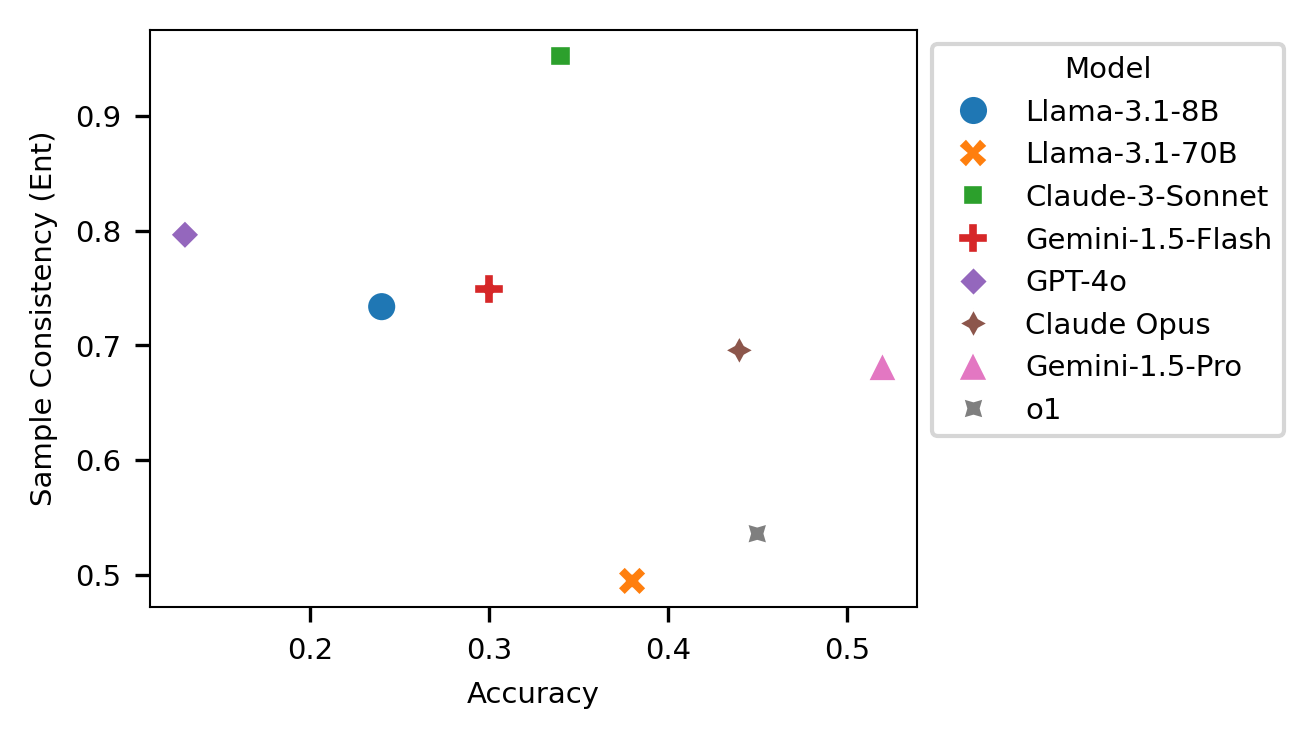

In [22]:
ax = sns.scatterplot(data=df_sc, x="Accuracy", y="Sample Consistency (Ent)", s=50, 
                     hue="Model", style="Model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()